In [112]:
# Load librarie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

In [113]:
# Import datasets 

# Train set
df_train = pd.read_csv(r"C:\Users\Walte\Desktop\House pricing\train.csv")
print(f"Train set info:\n{df_train.shape}\n")

# Test set
df_test = pd.read_csv(r"C:\Users\Walte\Desktop\House pricing\test.csv")
print(f"Test set info:\n{df_test.shape}")

Train set info:
(1460, 81)

Test set info:
(1459, 80)


In [114]:
# train data info 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [115]:
# Comparing train and test data set with the same column 
dif_1 = [x for x in df_train.columns if x not in df_test.columns]
print(f"Columns present in df_train and not in df_test: {dif_1}\n")

dif_2 = [x for x in df_test.columns if x not in df_train.columns]
print(f"Columns present in df_test and not in df_train: {dif_2}")

Columns present in df_train and not in df_test: ['SalePrice']

Columns present in df_test and not in df_train: []


In [116]:
# Drop the 'Id' column from the train set becuase it is not a factor 
df_train.drop(["Id"], axis=1, inplace=True)

# Save the list of 'Id' before dropping it from the test set
Id_test_list = df_test["Id"].tolist()
df_test.drop(["Id"], axis=1, inplace=True)

In [117]:
# Select the numerical data of train data 
df_train_num = df_train.select_dtypes(exclude=["object"])
df_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [118]:
# Quasi-constant (95%)
sel = VarianceThreshold(threshold=0.05)

# fit finds the features with constant variance
sel.fit(df_train_num.iloc[:, :-1])


# Number that not constant 
print(f"Number of retained features: {sum(sel.get_support())}")
print(f"Number of quasi_constant features: {len(df_train_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_train_num.iloc[:, :-1].columns if x not in df_train_num.iloc[:, :-1].columns[sel.get_support()]]
print(f"Quasi-constant features to be dropped: {quasi_constant_features_list}")


# Let's drop these columns from df_train_num
df_train_num.drop(quasi_constant_features_list, axis=1, inplace=True)

Number of retained features: 35
Number of quasi_constant features: 1
Quasi-constant features to be dropped: ['KitchenAbvGr']


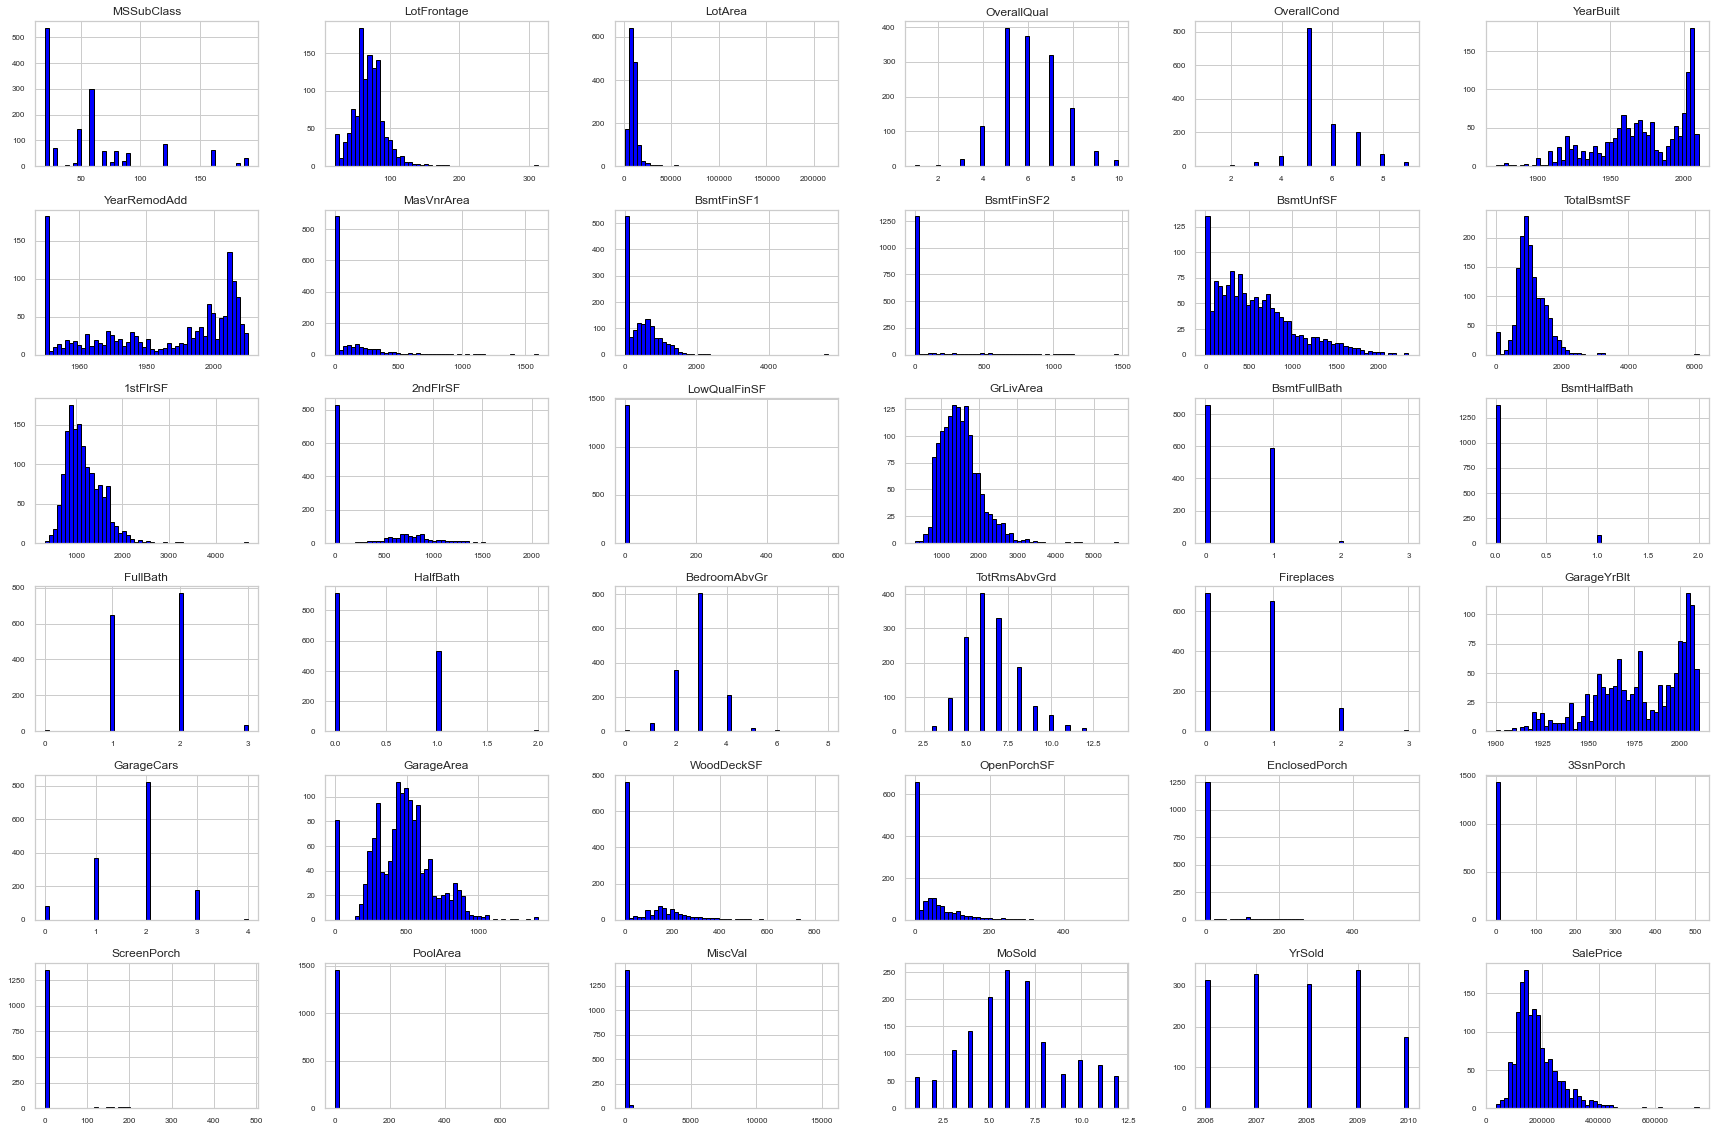

In [119]:
# Visualization of all the numerical data
fig_ = df_train_num.hist(figsize=(30, 20), bins=50, color="blue",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

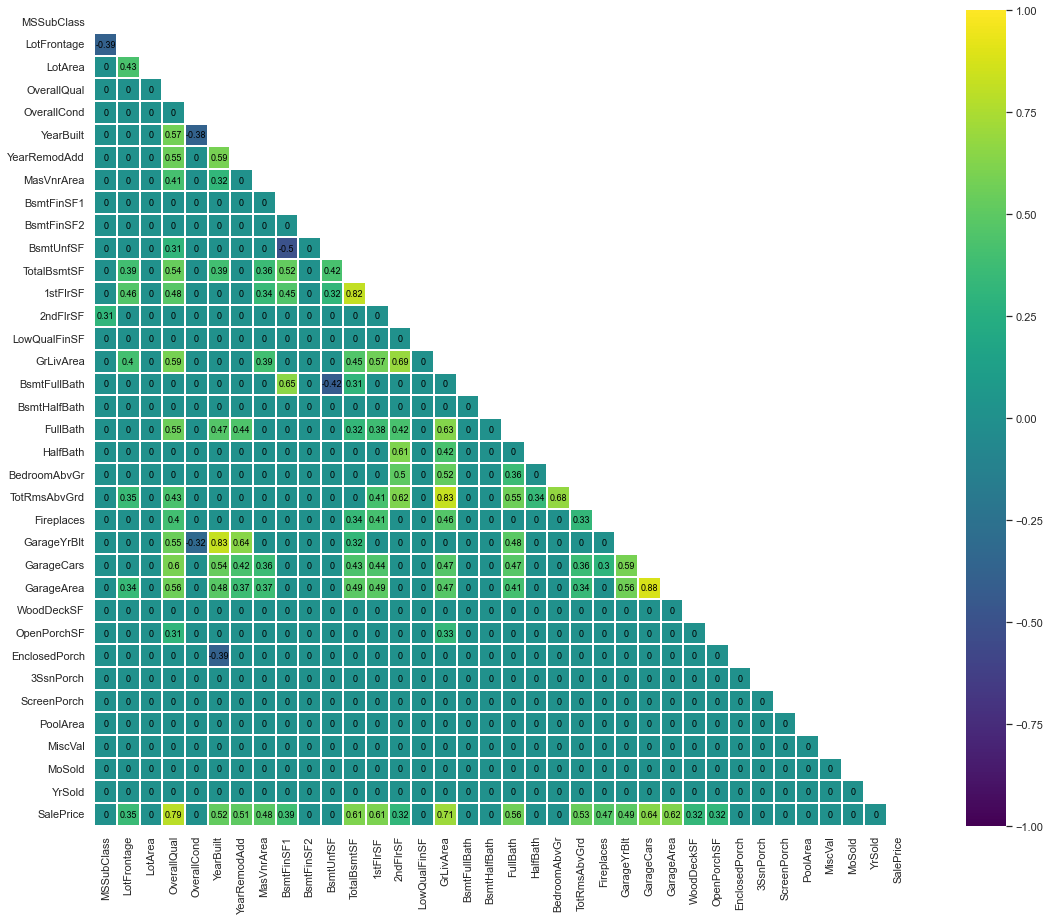

In [120]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'

pd.options.display.float_format = "{:,.2f}".format
corr_matrix = df_train_num.corr()
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

In [121]:
# 18 features that are important and correlated (correlation higher than absolute 0.3) with our target variable 'SalePrice'. 
# In next, select features where the correlation with 'SalePrice' is higher than |0.3| 

In [122]:
# SalePrice
df_num_corr = df_train_num.corr()["SalePrice"][:-1]

# r2 > 0.5
high_features_list = df_num_corr[abs(
    df_num_corr) >= 0.5].sort_values(ascending=False)
print(
    f"{len(high_features_list)} strongly correlated values with SalePrice:\n{high_features_list}\n")

# r2 < 0.5 & r2 > 0.3
low_features_list = df_num_corr[(abs(df_num_corr) < 0.5) & (
    abs(df_num_corr) >= 0.3)].sort_values(ascending=False)
print(
    f"{len(low_features_list)} slightly correlated values with SalePrice:\n{low_features_list}")

10 strongly correlated values with SalePrice:
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64

8 slightly correlated values with SalePrice:
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


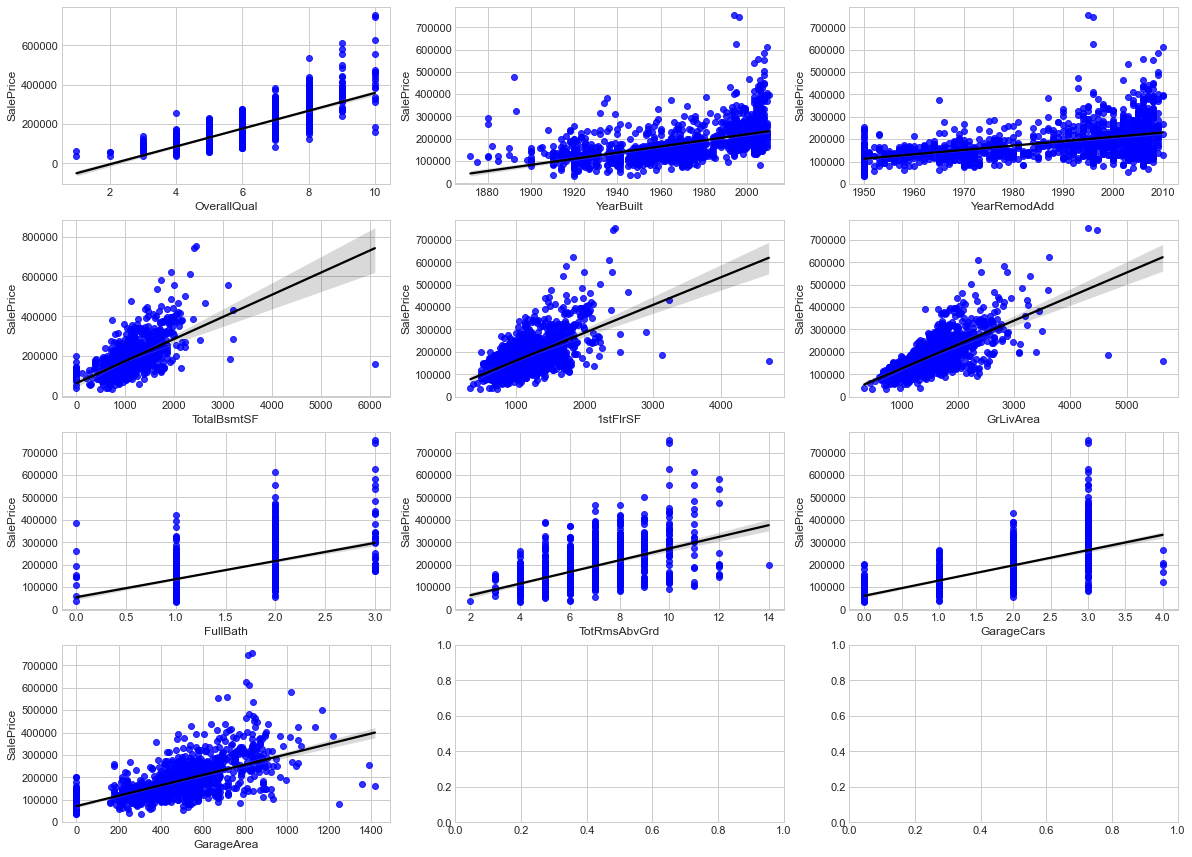

In [123]:
# Features with high correlation (higher than 0.5), plot the correlation of each featyre to salesprice 
strong_features = df_num_corr[abs(df_num_corr) > 0.5].index.tolist()
strong_features.append("SalePrice")
df_strong_features = df_train_num.loc[:, strong_features]

plt.style.use("seaborn-whitegrid")  
fig, ax = plt.subplots(round(len(strong_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    if i < len(strong_features)-1:
        sns.regplot(x=strong_features[i], y="SalePrice", data=df_strong_features, ax=ax, scatter_kws={
                    "color": "blue"}, line_kws={"color": "black"})

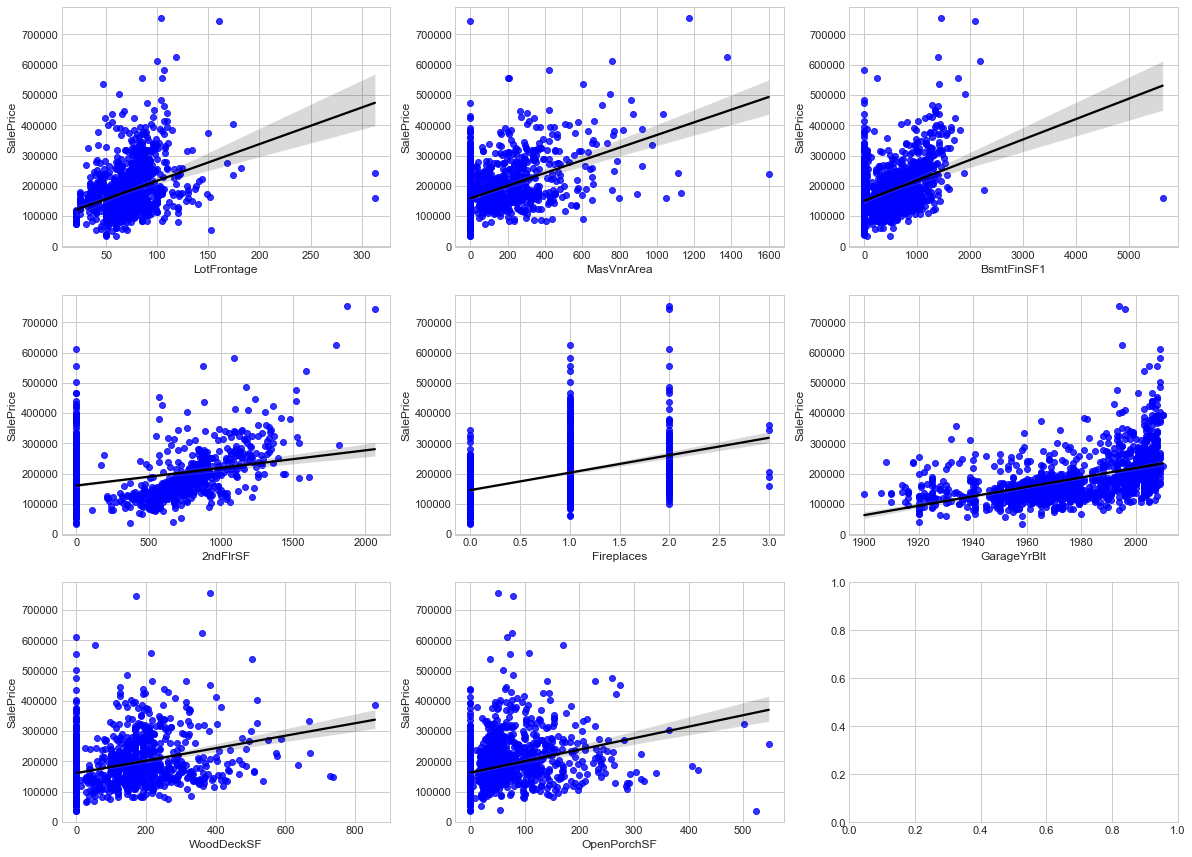

In [124]:
# Features with low correlation (between 0.3 and 0.5), plot the correlation of each feature with Salesprice 
low_features = df_num_corr[(abs(df_num_corr) >= 0.3) & (
    abs(df_num_corr) < 0.5)].index.tolist()
low_features.append("SalePrice")

df_low_features = df_train_num.loc[:, low_features]

plt.style.use("seaborn-whitegrid")  
fig, ax = plt.subplots(round(len(low_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    if i < len(low_features) - 1:
        sns.regplot(x=low_features[i], y="SalePrice", data=df_low_features, ax=ax, scatter_kws={
                    "color": "blue"}, line_kws={"color": "black"},)

In [125]:
# Remove observations to avoid influencing the prediction model

In [126]:
# Define the list of numerical fetaures to keep
list_of_numerical_features = strong_features[:-1] + low_features

# Let's select these features form our train set
df_train_num = df_train_num.loc[:, list_of_numerical_features]

# The same features are selected from the test set (-1 -> except 'SalePrice')
df_test_num = df_test.loc[:, list_of_numerical_features[:-1]]

Text(0, 0.5, 'Column Name\n')

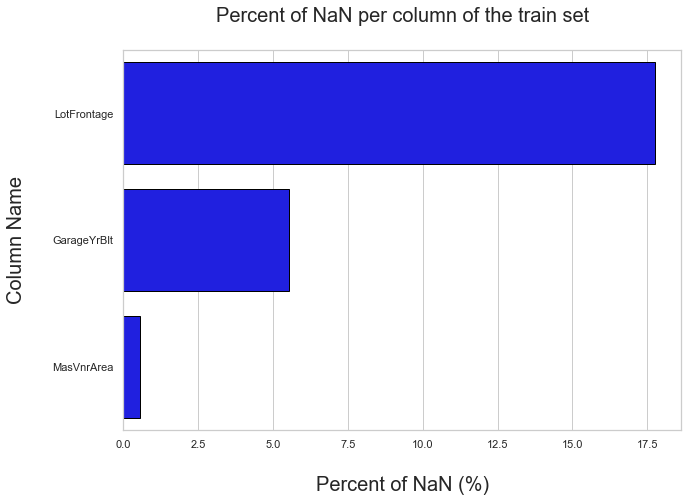

In [127]:
# Check the non-number (NAN) of the train set by ploting percent of missing values per column
column_with_nan = df_train_num.columns[df_train_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_train_num[i].isnull().sum()*100/len(df_train_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [128]:
# Imputation of missing values (NaN) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(df_train_num))
df_train_imputed.columns = df_train_num.columns

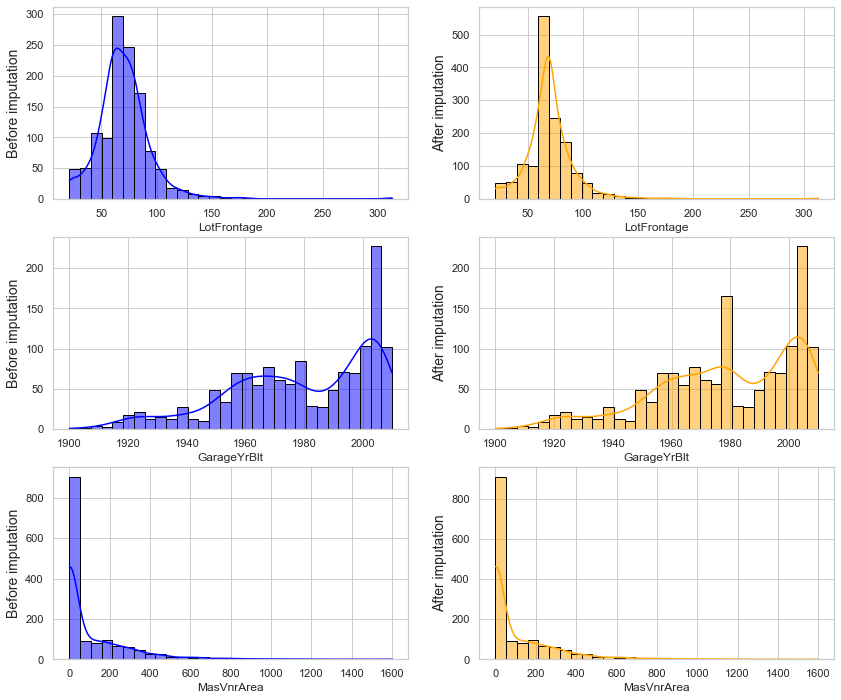

In [129]:
# Let's check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_train_num[feature],
                     kde=True, bins=30, color="blue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_train_imputed[feature],
                     kde=True, bins=30, color="orange", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

In [130]:
# For "LotFrontage" and "GarageYrBlt" the distributions have changed after imputations. 
# There is an over-representation of the median class compare ot the original distribution. However, the distribution remains the same for "MasVnrArea". 
# Thus, to avoid any error related to the imputation I keep only the feature "MasVnrArea" for my analyses.

In [131]:
# Drop 'LotFrontage' and 'GarageYrBlt'
df_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)
df_train_imputed.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,Fireplaces,WoodDeckSF,OpenPorchSF,SalePrice
0,7.00,"2,003.00","2,003.00",856.00,856.00,"1,710.00",2.00,8.00,2.00,548.00,196.00,706.00,854.00,0.00,0.00,61.00,"208,500.00"
1,6.00,"1,976.00","1,976.00","1,262.00","1,262.00","1,262.00",2.00,6.00,2.00,460.00,0.00,978.00,0.00,1.00,298.00,0.00,"181,500.00"
2,7.00,"2,001.00","2,002.00",920.00,920.00,"1,786.00",2.00,6.00,2.00,608.00,162.00,486.00,866.00,1.00,0.00,42.00,"223,500.00"
3,7.00,"1,915.00","1,970.00",756.00,961.00,"1,717.00",1.00,7.00,3.00,642.00,0.00,216.00,756.00,1.00,0.00,35.00,"140,000.00"
4,8.00,"2,000.00","2,000.00","1,145.00","1,145.00","2,198.00",2.00,9.00,3.00,836.00,350.00,655.00,"1,053.00",1.00,192.00,84.00,"250,000.00"


In [132]:
# The columns that have been deleted in the train set must also be deleted in the test 

In [133]:
df_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)

Text(0, 0.5, 'Column Name\n')

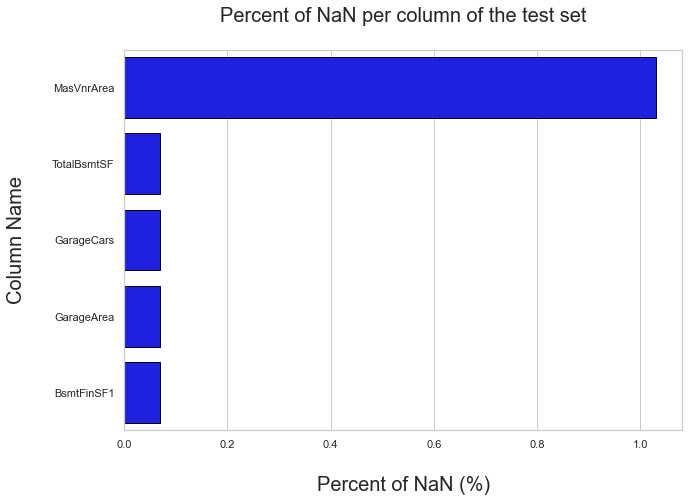

In [134]:
# Repeat NAN for test set by plotting percent of missing value 

column_with_nan = df_test_num.columns[df_test_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_num[i].isnull().sum()*100/len(df_test_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")

p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [135]:
# Repeat Imputation 
my_imputer = SimpleImputer(strategy="median")
df_test_imputed = pd.DataFrame(my_imputer.fit_transform(df_test_num))
df_test_imputed.columns = df_test_num.columns

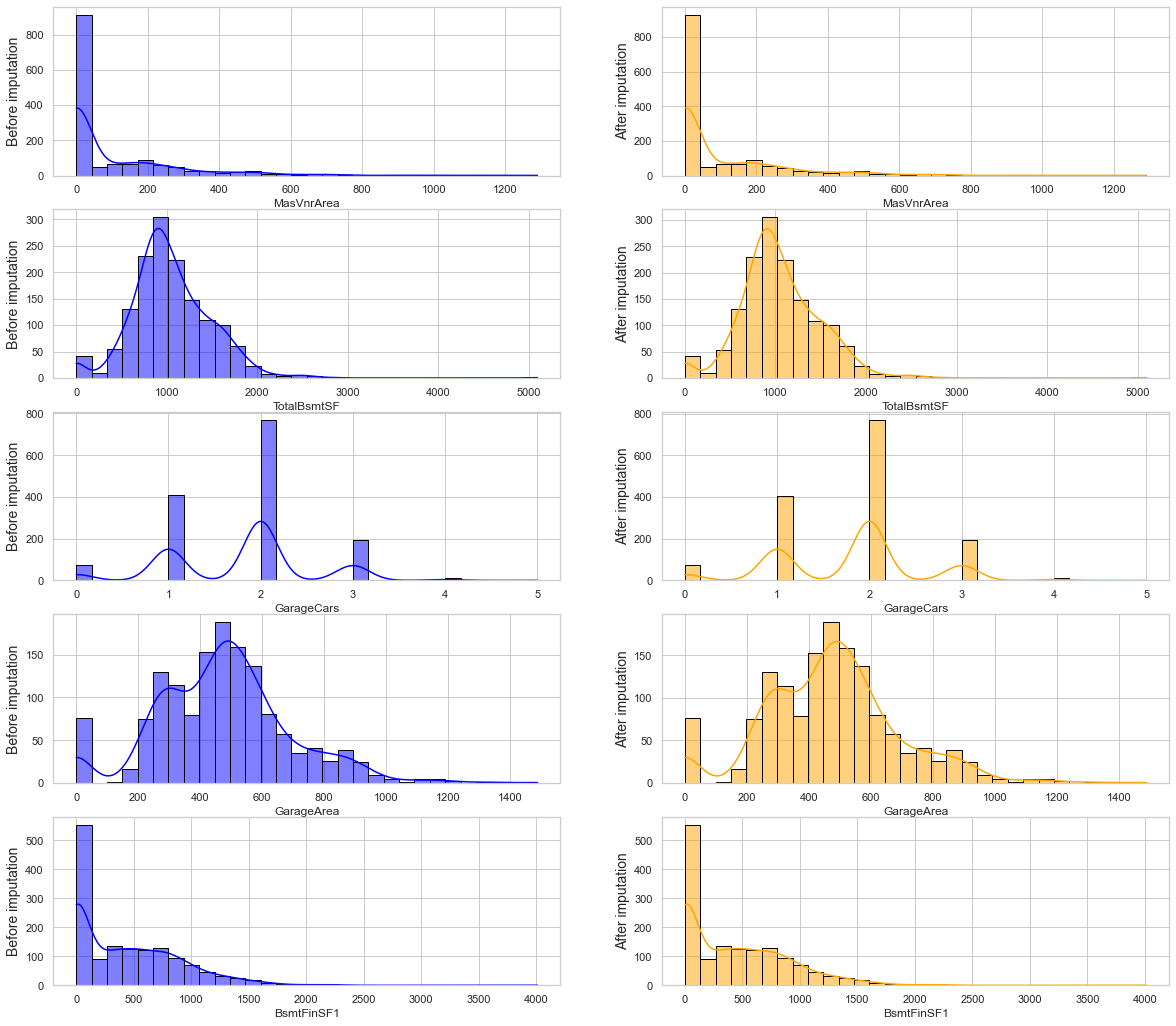

In [136]:
# Comparation before and after imputation 


sns.set(rc={"figure.figsize": (20, 18)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(5, 2)

for feature, fig_pos in zip(tab["Column"].tolist(), range(0, 6)):

    """Features distribution before and after imputation"""
    # before 
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_test_num[feature],
                     kde=True, bins=30, color="blue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)
    
    # after 
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_test_imputed[feature],
                     kde=True, bins=30, color="orange", edgecolor="black",)
    q.set_ylabel(f"After imputation", fontsize=14)

In [137]:
# the percentage of NaN in each of these fetaures did not exceed 1.5%. Imputation success 

In [138]:
# Categorical to Quantitative relationship
categorical_features = [
    i for i in df_train.columns if df_train.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
df_train_categ = df_train[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')
df_test_categ = df_test[categorical_features[:-1]]

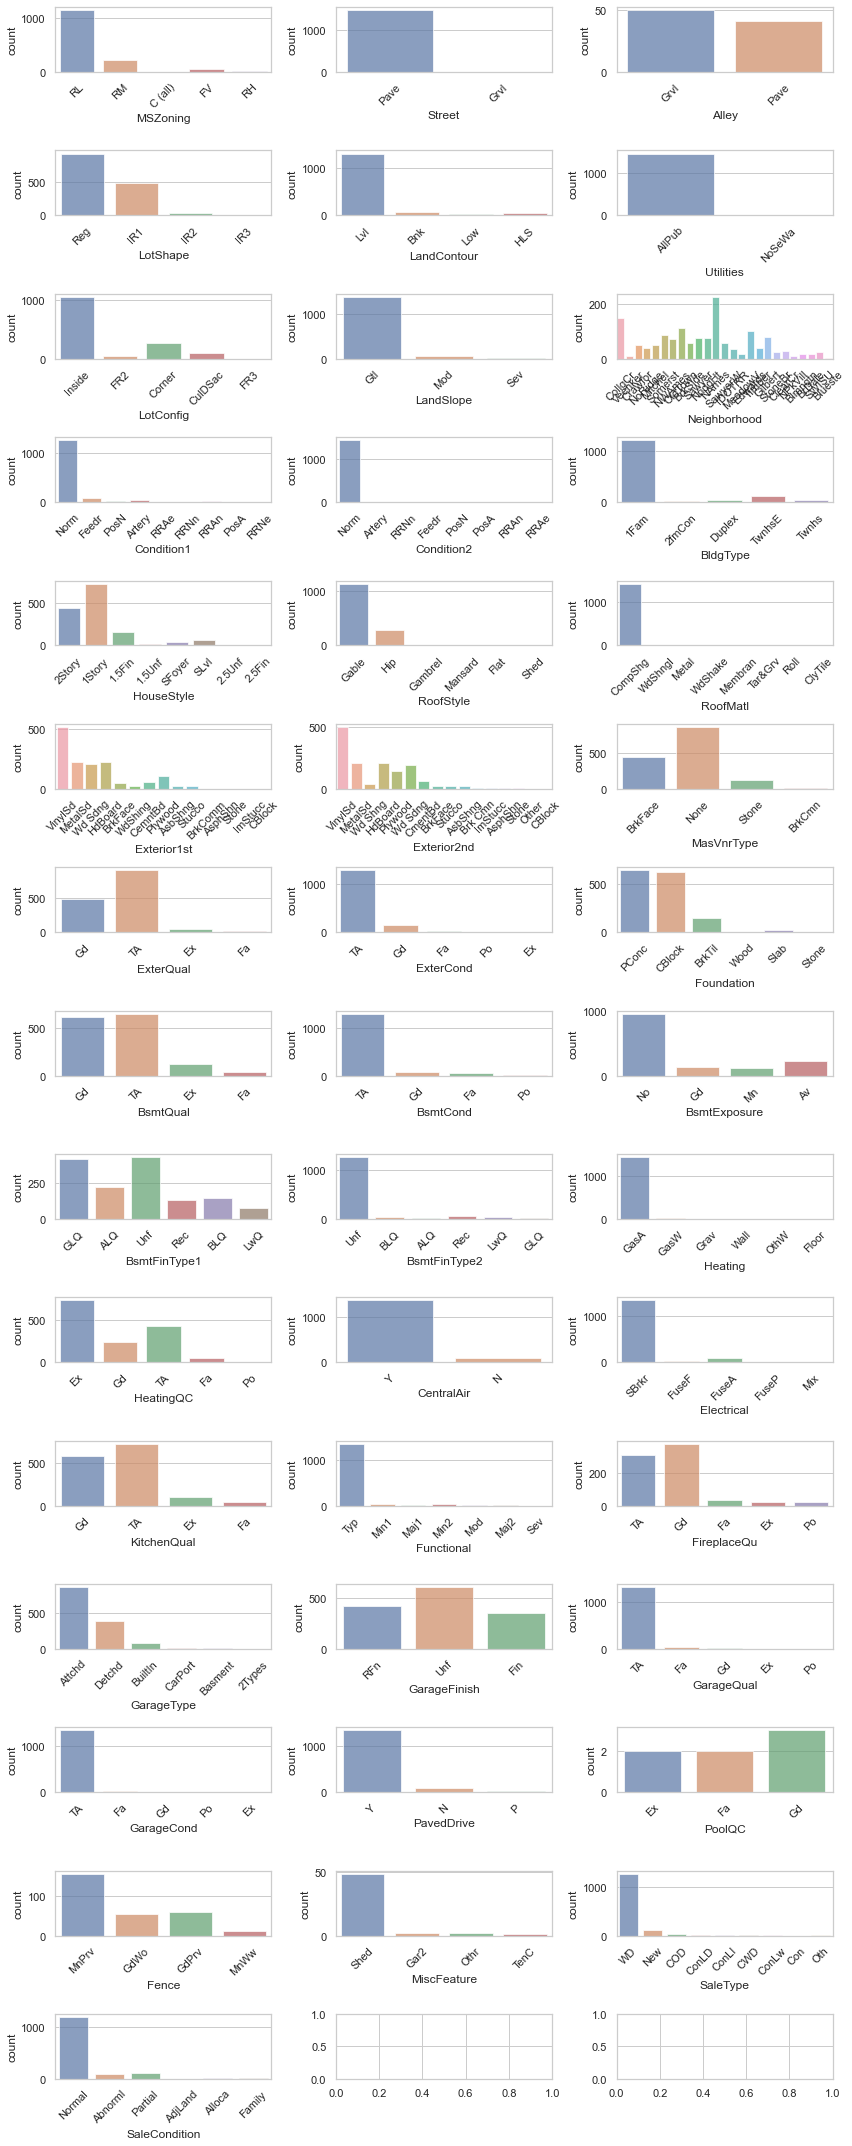

In [139]:
# Countplot for each of the categorical features in the train set
fig, axes = plt.subplots(
    round(len(df_train_categ.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(
            x=df_train_categ.columns[i], alpha=0.7, data=df_train_categ, ax=ax)

fig.tight_layout()

In [140]:
# Drop the unimportant parts 

columns_to_drop = [
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Condition2",
    "RoofMatl",
    "CentralAir",
    "GarageQual",
    "GarageCond",
    "SaleType",
    "PavedDrive",
    "LandContour",
    "ExterCond",
    "GarageCond",
    "Heating",
    "MiscFeature",
    "BsmtFinType2",
    "Functional",
    "GarageQual",
    "GarageCond",
]

# Train set
df_train_categ.drop(columns_to_drop, axis=1, inplace=True)

# Test set
df_test_categ.drop(columns_to_drop, axis=1, inplace=True)

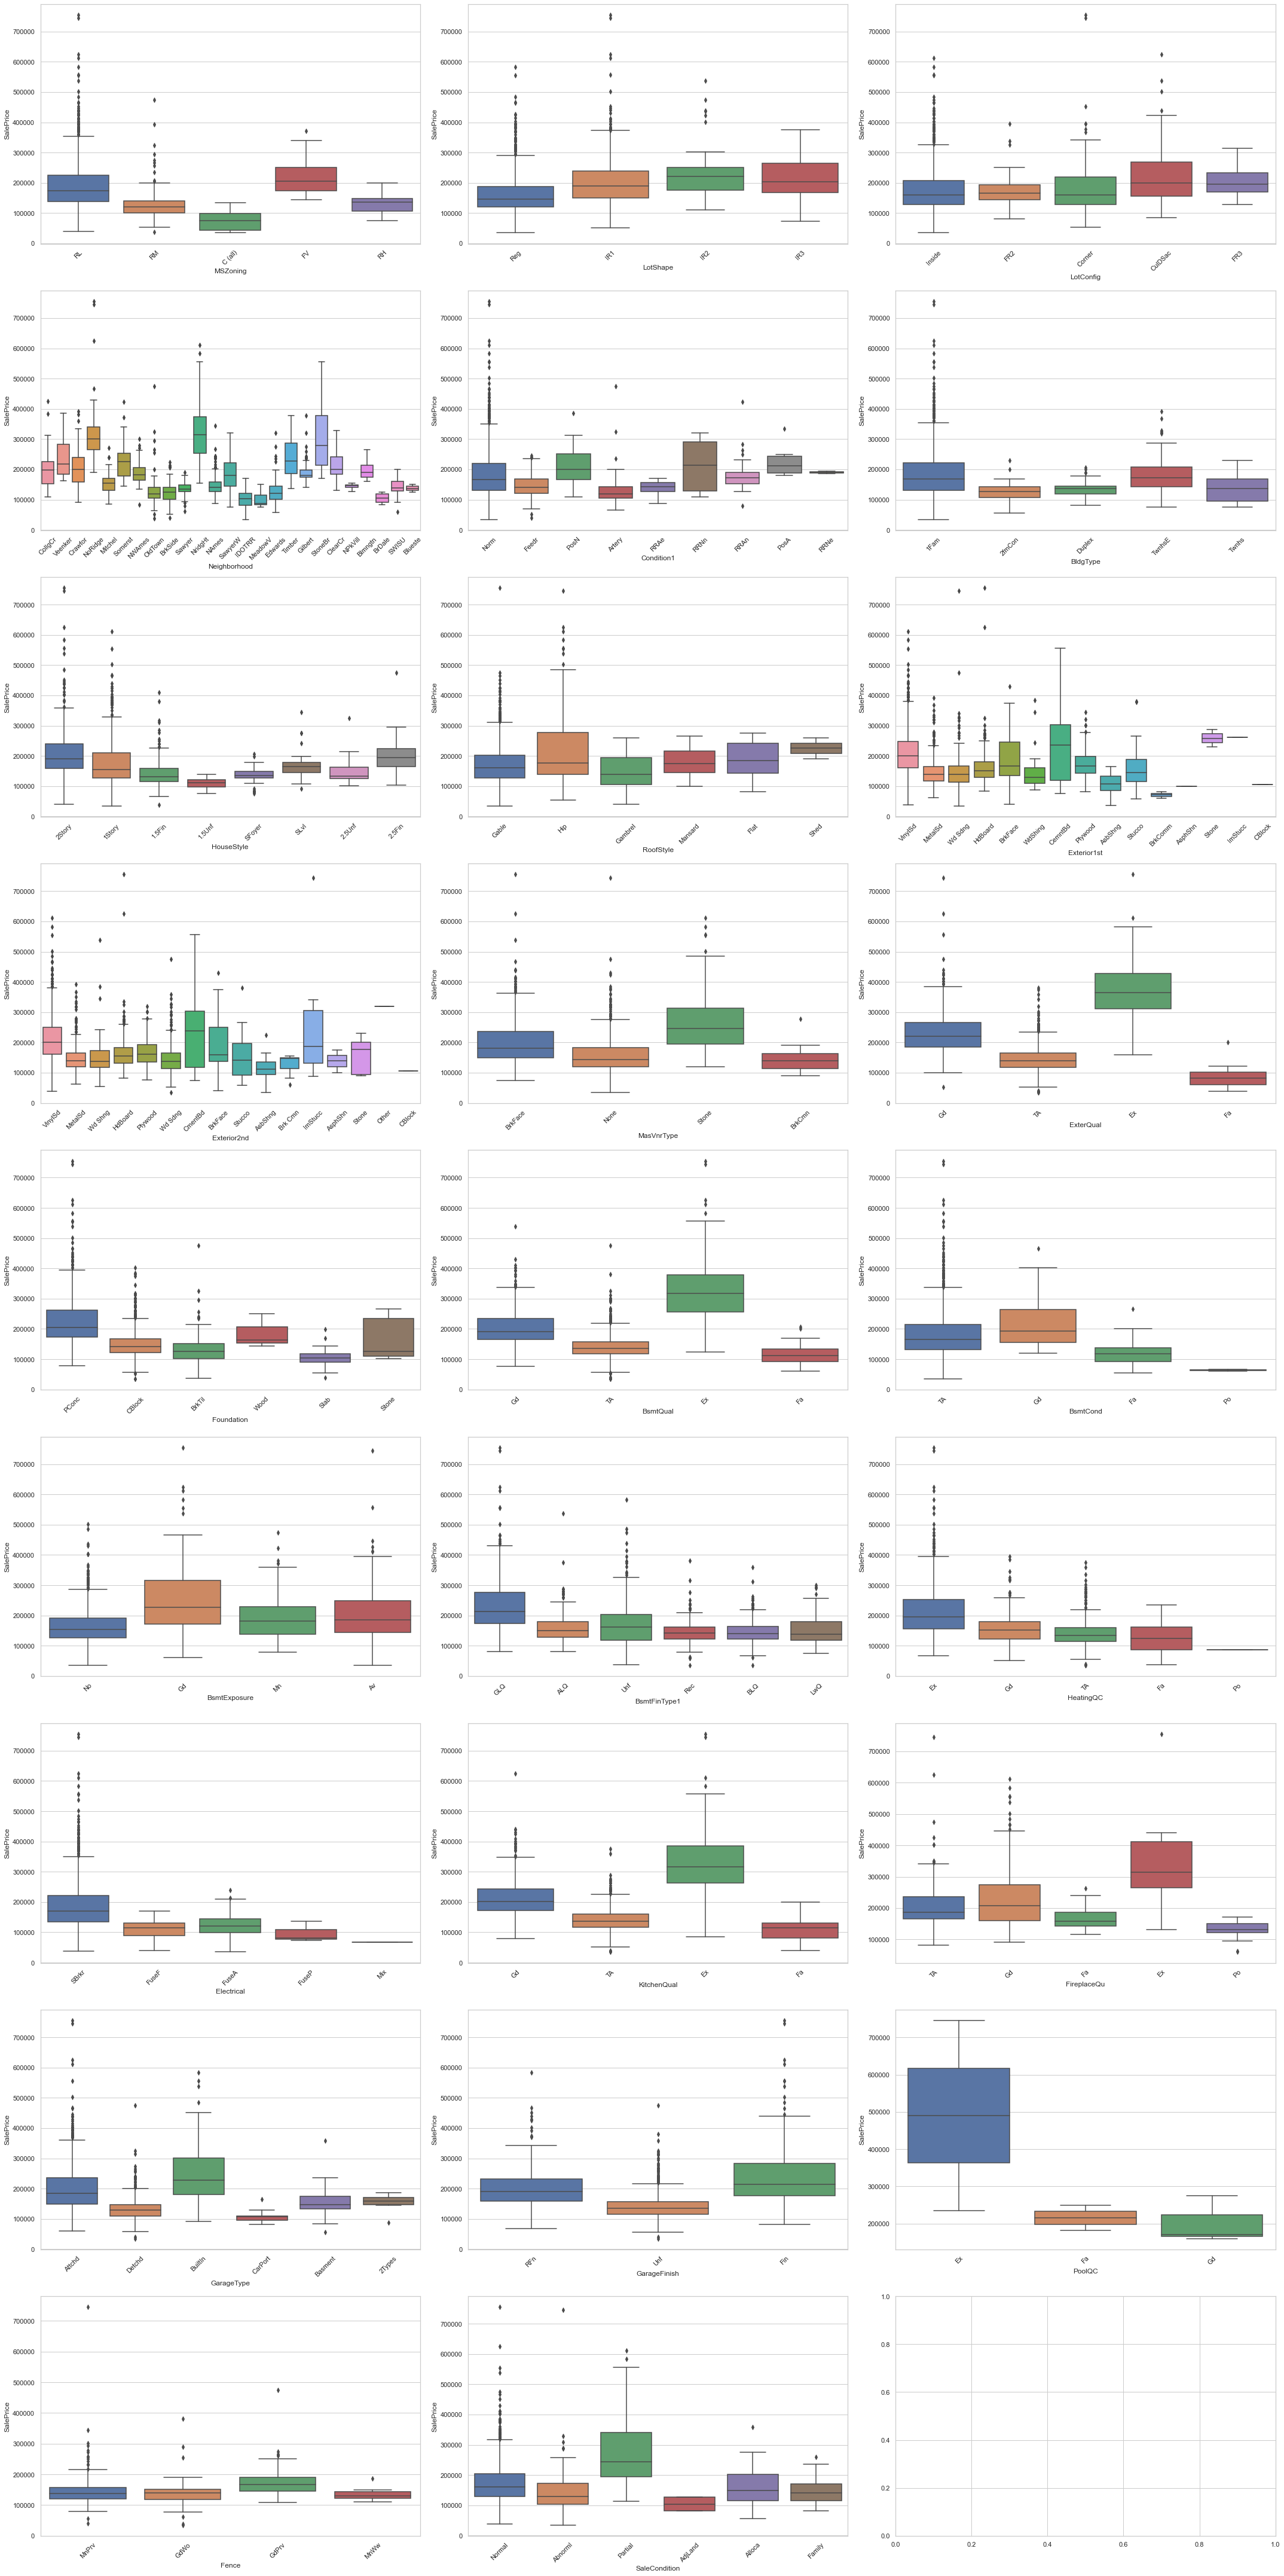

In [141]:
# Create boxplot show the variation of the target 'SalePrice' in each of the categorical features
fig, axes = plt.subplots(
    round(len(df_train_categ.columns)/3), 3, figsize=(30, 60))

for i, ax in enumerate(fig.axes):
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(
            x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax)

fig.tight_layout()

In [142]:
#  plot the contingency table and perform the Chi square test in order to identify these codependency

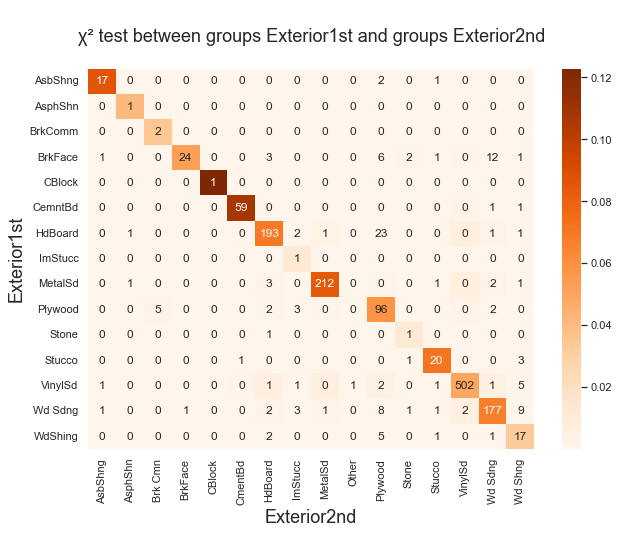

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



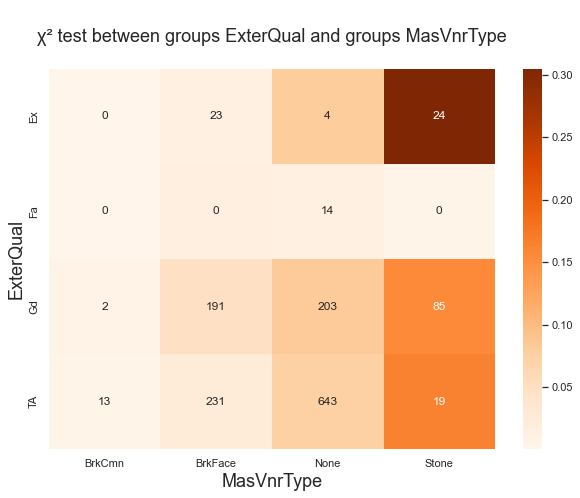

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54



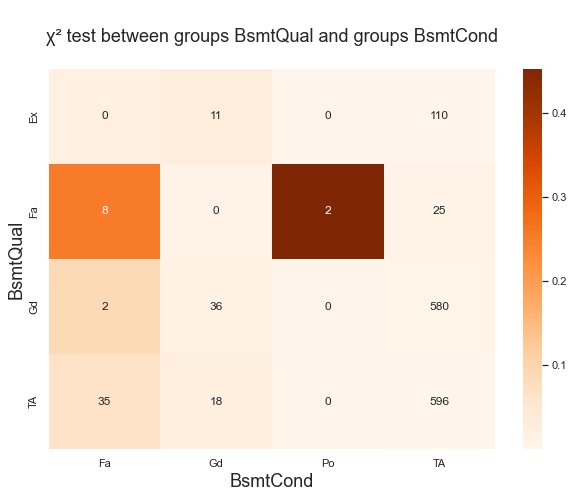

P-Value of the ChiSq Test bewteen BsmtQual and BsmtCond is: 1.9371809126533347e-31



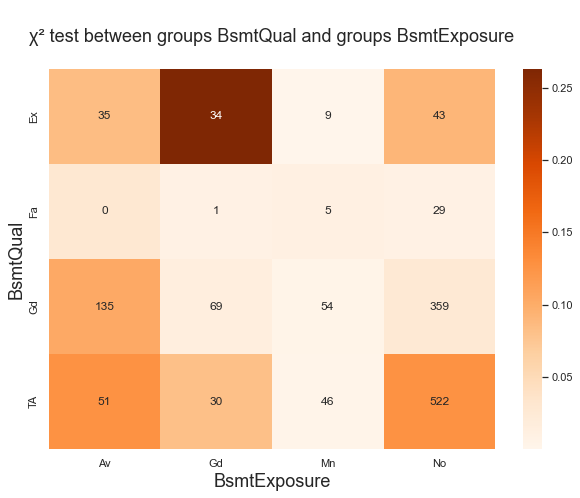

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32



In [143]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual", "BsmtQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtCond", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_train_categ[i], columns=df_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

In [144]:
# p-value is significant for all tests so there is some co-dependence between these variables.
#  For this I will drop 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' and 'MasVnrType'

# Train set
df_train_categ.drop(Y, axis=1, inplace=True)

# Test set
df_test_categ.drop(Y, axis=1, inplace=True)

Text(0, 0.5, 'Column Name\n')

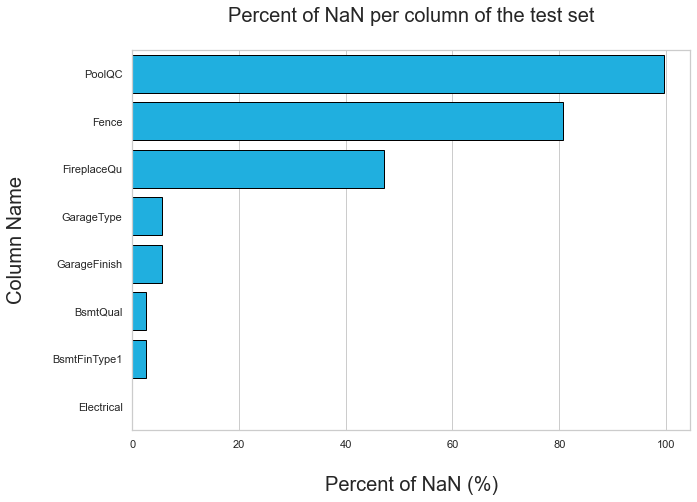

In [145]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_train_categ.columns[df_train_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_train_categ[i].isnull().sum() * 100 / len(df_train_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [146]:
# Drop the features where the percentage of NaN is higher than 5% to avoid introducing any error. 
# Then impute the NaN of 'BsmtQual' and 'Electrical' by the corresponding modal class

In [147]:
# Drop the features where the percentage of NaN is higher than 5%
df_train_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish"], axis=1, inplace=True,)

In [148]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_train_categ["Electrical"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

In [149]:
# The columns that have been deleted in the train set must also be deleted in the test set 
# so that the two data sets remain identical for the modeling and prediction.

In [150]:
# Drop the same features from test set as for the train set
df_test_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                    "GarageType", "GarageFinish"], axis=1, inplace=True,)

Text(0, 0.5, 'Column Name\n')

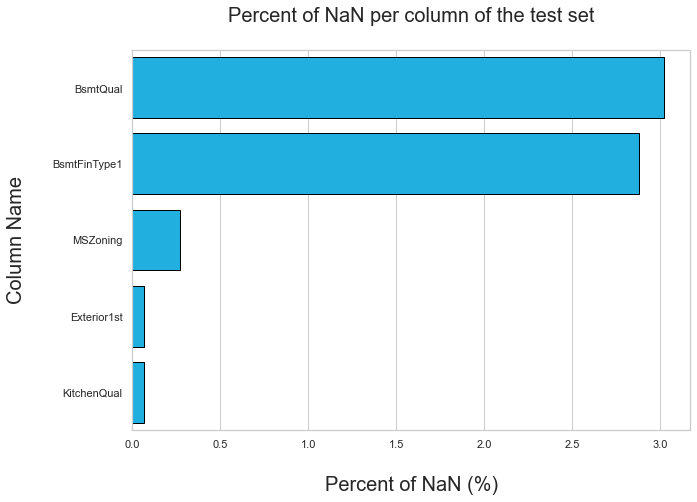

In [151]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_test_categ.columns[df_test_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_categ[i].isnull().sum() * 100 / len(df_test_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [152]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_test_categ["BsmtFinType1"].mode().iloc[0],
                   "MSZoning": df_test_categ["MSZoning"].mode().iloc[0],
                   "Exterior1st": df_test_categ["Exterior1st"].mode().iloc[0],
                   "KitchenQual": df_test_categ["KitchenQual"].mode().iloc[0]}

df_test_categ = df_test_categ.fillna(value=categ_fill_null)

In [153]:
# Transform Categorical features into Binary features

In [154]:
# Train set
for i in df_train_categ.columns.tolist()[:-1]:
    df_dummies = pd.get_dummies(df_train_categ[i], prefix=i)

    # merge both tables
    df_train_categ = df_train_categ.join(df_dummies)

# Select the binary features only
df_train_binary = df_train_categ.iloc[:, 18:]
df_train_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [155]:
# Test set
for i in df_test_categ.columns.tolist():
    df_dummies = pd.get_dummies(df_test_categ[i], prefix=i)

    # merge both tables
    df_test_categ = df_test_categ.join(df_dummies)

# Select the binary features only
df_test_binary = df_test_categ.iloc[:, 17:]
df_test_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [156]:
# in df_test_binary there is 118 columns while in df_train_binary there is 122. Let's see which columns are missing from df_test_binary

In [157]:
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix']

Features present in df_test_categ set and absent in df_train_categ: []


In [158]:
# Four of the binary features are absent from the test set. 
# Thus, these features will be dropped from the train in order to have the same columns in both data set

In [159]:
# Let's drop these columns from df_train_binary
df_train_binary.drop(dif_1, axis=1, inplace=True)

# Check again if the column headings are the same in both data set
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


In [160]:
# Add binary features to numreical features
# Train set
df_train_new = df_train_imputed.join(df_train_binary)
print(f"Train set: {df_train_new.shape}")

# Test set
df_test_new = df_test_imputed.join(df_test_binary)
print(f"Test set: {df_test_new.shape}")

Train set: (1460, 135)
Test set: (1459, 134)


In [161]:
# both features "WoodDeckSF" and "OpenPorchSF" a high number of 0 values with a correspondingly high price variation. 
# These outliers should be deleted.
# However, since the number of these outliers is very important, the best thing to do is to drop these columns.

In [162]:
# Drop "WoodDeckSF" and "OpenPorchSF"
df_train_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)
df_test_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)

In [163]:
# Let's handle the outliers in "GrLivArea", "TotalBsmtSF" and "GarageArea"
# Outliers in "GrLivArea"
outliers1 = df_train_new[(df_train_new["GrLivArea"] > 4000) & (
    df_train_new["SalePrice"] <= 200000)].index.tolist()

# Outliers in "TotalBsmtSF"
outliers2 = df_train_new[(df_train_new["TotalBsmtSF"] > 3000) & (
    df_train_new["SalePrice"] <= 400000)].index.tolist()

# Outliers in "GarageArea"
outliers3 = df_train_new[(df_train_new["GarageArea"] > 1200) & (
    df_train_new["SalePrice"] <= 300000)].index.tolist()

# List of all the outliers
outliers = outliers1 + outliers2 + outliers3
outliers = list(set(outliers))
print(outliers)

# Drop these outlier
df_train_new = df_train_new.drop(df_train_new.index[outliers])

# Reset index
df_train_new = df_train_new.reset_index().drop("index", axis=1)

[1061, 581, 1190, 523, 332, 1298]


In [164]:
# While looking closley at the remaining features, we can notice that several of them designate a given surface of the property. 
# Thus, I will try to combine some of these surfaces into indicators without losing the information they provide.

In [165]:
# Define a function to calculate the occupancy rate of the first floor of the total living area


def floor_occupation(x):
    """First floor occupation of the total live area

    floor_occupation equation has the following form:
    (1st Floor Area * 100) / (Ground Live Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Ground Live Area = 0
        equation -- if Ground Live Area > 0
    """
    if x["GrLivArea"] == 0:
        return 0
    else:
        return x["1stFlrSF"] * 100 / x["GrLivArea"]


# Apply the function on train and test set
df_train_new["1stFlrPercent"] = df_train_new.apply(
    lambda x: floor_occupation(x), axis=1)

df_test_new["1stFlrPercent"] = df_test_new.apply(
    lambda x: floor_occupation(x), axis=1)

# Drop "1stFlrSF" and "2ndFlrSF"
df_train_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)
df_test_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)

In [166]:
# Define a function to calculate the occupancy rate of the finished basement area


def bsmt_finish(x):
    """Propotion of finished area in basement 

    bsmt_finish equation has the following form:
    (Finished Basement Area * 100) / (Total Basement Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Total Basement Area = 0
        equation -- if Total Basement Area > 0
    """
    if x["TotalBsmtSF"] == 0:
        return 0
    else:
        return x["BsmtFinSF1"] * 100 / x["TotalBsmtSF"]


# Apply the function on train and test set
df_train_new["BsmtFinPercent"] = df_train_new.apply(
    lambda x: bsmt_finish(x), axis=1)

df_test_new["BsmtFinPercent"] = df_test_new.apply(
    lambda x: bsmt_finish(x), axis=1)

# Drop "BsmtFinSF1"
df_train_new.drop(["BsmtFinSF1"], axis=1, inplace=True)
df_test_new.drop(["BsmtFinSF1"], axis=1, inplace=True)

In [167]:
# Convert Year of construction to Age of the house since the construction
df_train_new["AgeSinceConst"] = (
    df_train_new["YearBuilt"].max() - df_train_new["YearBuilt"])

df_test_new["AgeSinceConst"] = df_test_new["YearBuilt"].max() - \
    df_test_new["YearBuilt"]

# Drop "YearBuilt"
df_train_new.drop(["YearBuilt"], axis=1, inplace=True)
df_test_new.drop(["YearBuilt"], axis=1, inplace=True)

In [168]:
# Convert Year of remodeling to Age of the house since the remodeling
df_train_new["AgeSinceRemod"] = (
    df_train_new["YearRemodAdd"].max() - df_train_new["YearRemodAdd"])

df_test_new["AgeSinceRemod"] = (
    df_test_new["YearRemodAdd"].max() - df_test_new["YearRemodAdd"])

# Drop "YearRemodAdd"
df_train_new.drop(["YearRemodAdd"], axis=1, inplace=True)
df_test_new.drop(["YearRemodAdd"], axis=1, inplace=True)